In [31]:
from analysis.analysis import *
import matplotlib.pyplot as plt


root = "defaults"
gid = 10
default_LC_gid = 10

Read the raw sim data for a grid ID

In [32]:
grid_df = read_fulltake(
    f"../_server/sim_data/{root}/parquets/fulltake_gid{gid}.parquet",
    scale_position=True,
)

grid_df.rid.unique().size


4800

Histogram of hopping times _vs._ default limit-cycle cell

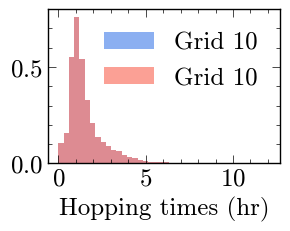

In [33]:
try:
    plt.figure(figsize=(3, 2), dpi=100)
    plt.hist(
        np.load(f"../_server/sim_data/{root}/hopping times/fulltake_gid{gid}.npy"),
        density=True,
        bins=40,
        alpha=0.75,
        color="cornflowerblue",
        label=f"Grid {gid}",
    )
    plt.hist(
        np.load(f"../_server/sim_data/{root}/hopping times/fulltake_gid{10}.npy"),
        density=True,
        bins=40,
        alpha=0.75,
        color="salmon",
        label=f"Grid {default_LC_gid}",
    )
    plt.xlabel("Hopping times (hr)")
    plt.legend()
    plt.show()
except FileNotFoundError:
    print("Make sure to first run compute_hopping_times.py")



Apply a time filter (min) to raw data and compute $x, v, a$
- Sims collect at a rate of 3 min

In [36]:
grid_df = apply_time_filter(grid_df, dt=3, base_rate=3)

nbins = 32
xva_df = get_xva_df(
    grid_df,
    nbins,
    yfile=f"../_server/sim_data/{root}/configs/grid_id{gid}/simbox.yaml",
)


Plot of $F(x, v)$ with streamlines and $\sigma(x, v)$

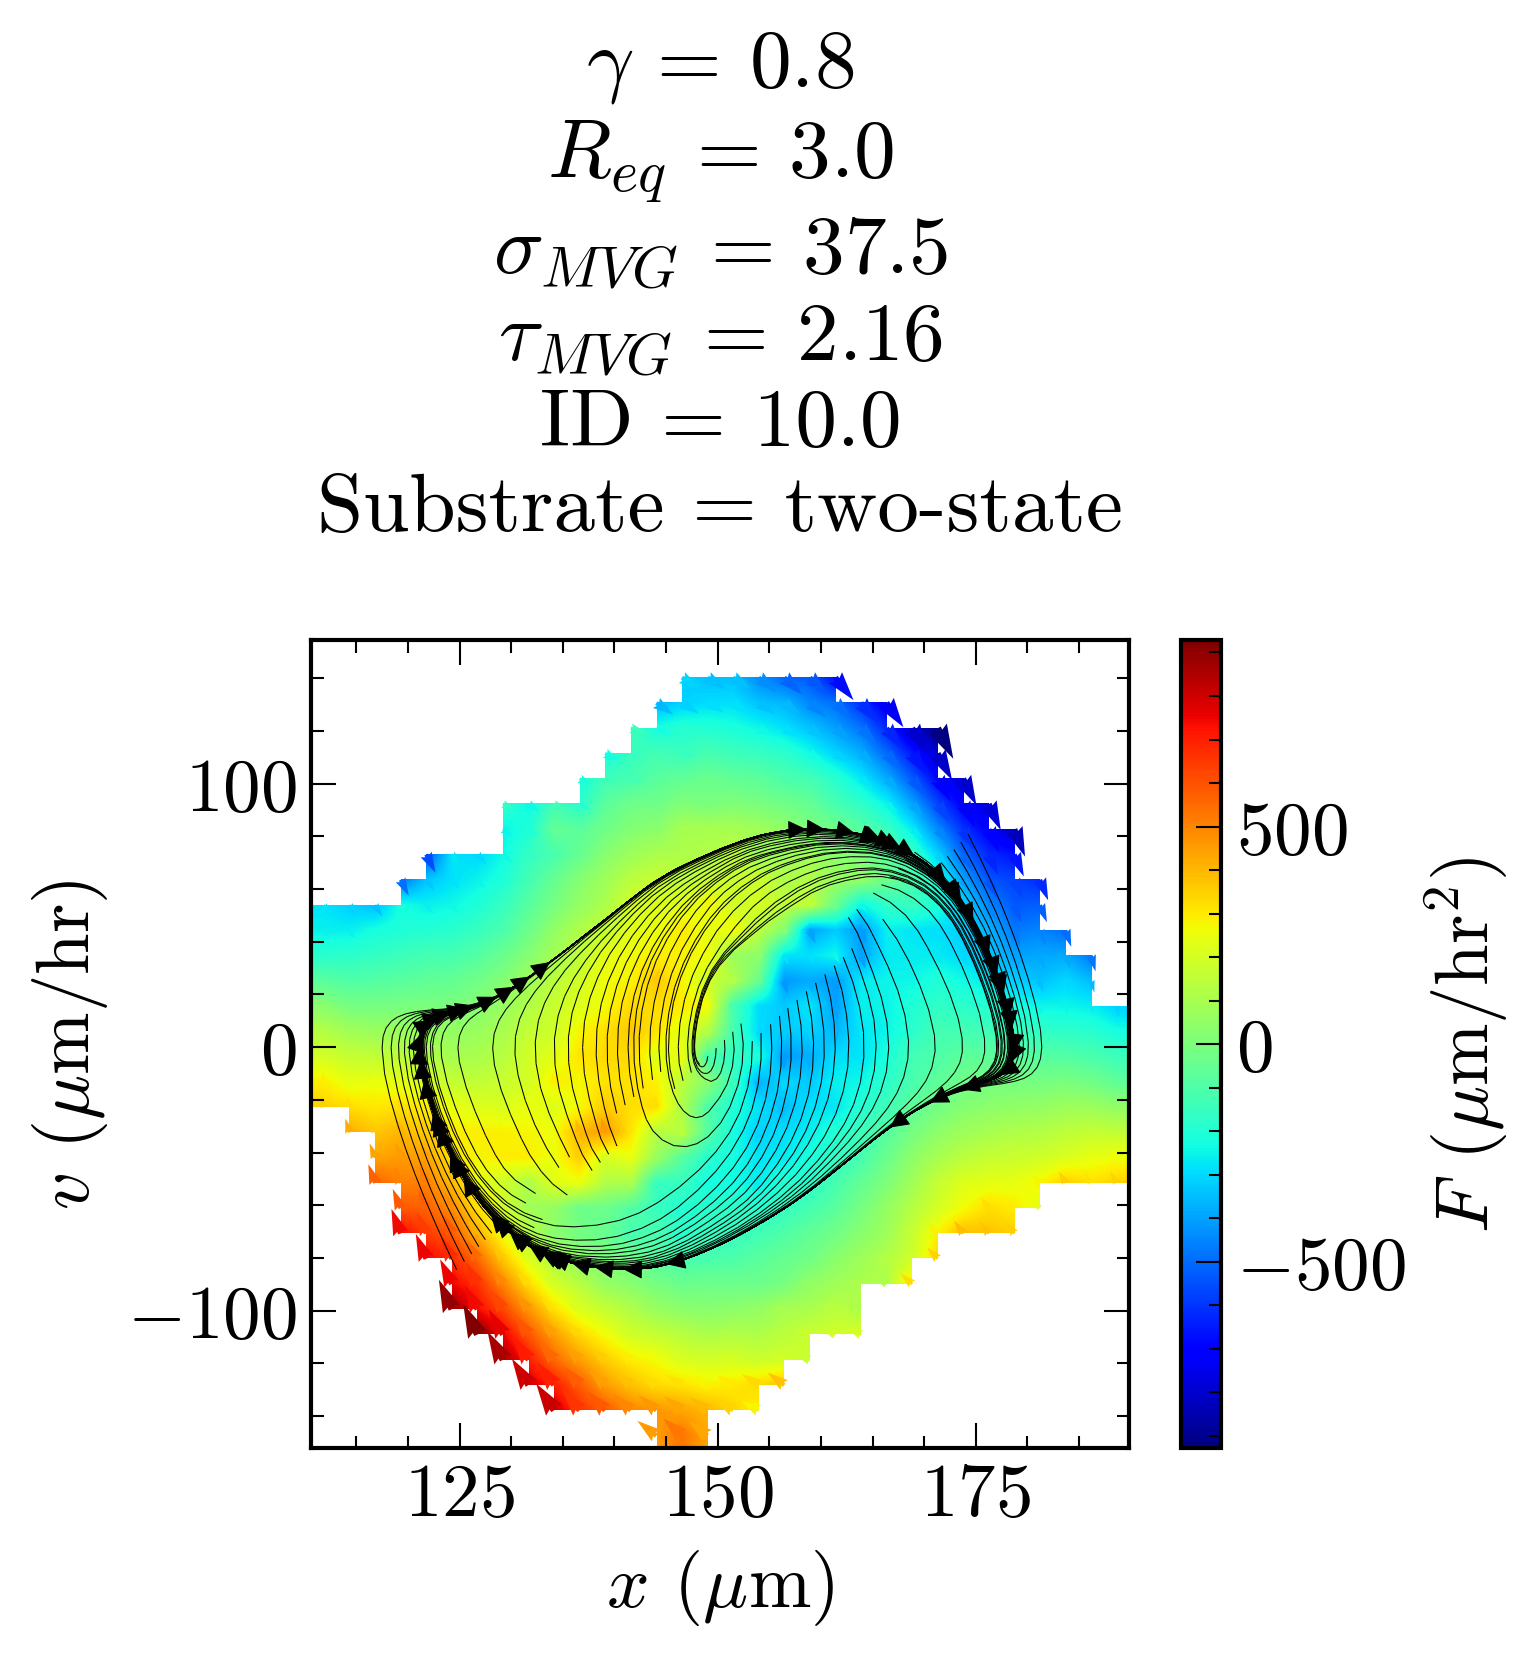

In [37]:
bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=10)

xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]
bounds_tup = (xmin, xmax, vmin, vmax, nbins)

plot_title = make_title(xva_df)
title = {"label": plot_title, "fontsize": 20}

init_pts = linear_lattice(xmin, xmax, vmin, vmax, n_pts=100)
# init_pts = init_pts[np.where(init_pts[np.where(init_pts[:, 0] < 155)[0]] > 145)[0]]
fig, ax = plt.subplots(1, 2, figsize=(11, 3.5), dpi=300)

ax[0].set_title(**title)
F_streamplot(
    F,
    bounds_tup,
    stream_init_pts=init_pts,
    imshow_kwargs={"interpolation": "bilinear", "origin": "lower", "cmap": "jet"},
    streamplot_kwargs={
        "integration_direction": "forward",
        "color": "black",
        "broken_streamlines": False,
        "density": 1,
        "linewidth": 0.25,
    },
    do_try=True,
    ax=ax[0],
)

im = ax[1].imshow(
    sigma,
    extent=[xmin, xmax, vmin, vmax],
    interpolation="bilinear",
    origin="lower",
    cmap="viridis",
)

# ax[0].scatter(init_pts[:, 0], init_pts[:, 1], s=5, color="red")
# ax[1].set_xlabel(r"$x$ ($\mu$m)")
# ax[1].set_ylabel(r"$v$ ($\mu$m/hr)")
# cbar = plt.colorbar(im, ax=ax[1])
# cbar.set_label(r"$\sigma$ ($\mu$m/hr$^{-3/2}$)")
# ax[1].set_aspect("auto")
ax[1].remove()

plt.subplots_adjust(wspace=0.5)
plt.show()


Plot $F(x\rightarrow 0, v)$

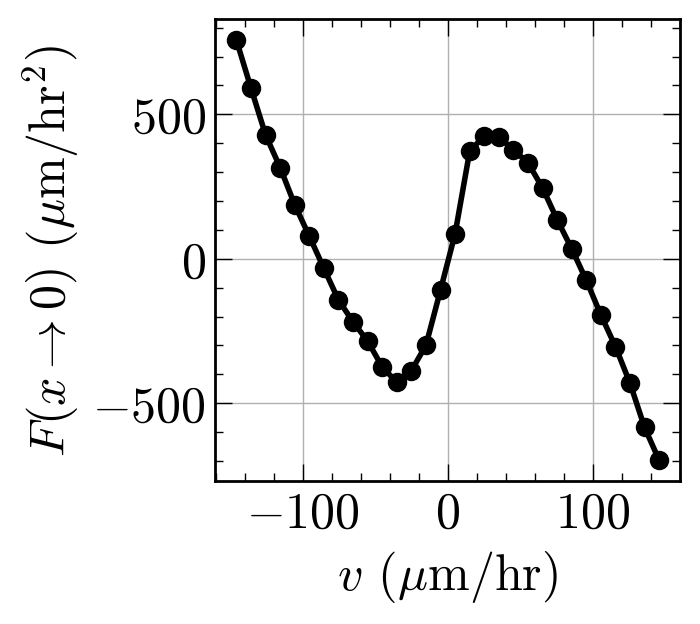

In [15]:
X, Y, init_pts = full_lattice(F, xmin, xmax, vmin, vmax, nbins)

# raw
v, f = evaluate_F_v_x0(Y, F, nbins)
lim = np.fabs([v.min(), v.max()]).min()
v_interp = np.linspace(-lim, lim, 30)
f_interp = np.interp(v_interp, v, f)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
ax.plot(v_interp, f_interp, "-o", lw=2, color="black")
ax.grid(which="major")
ax.set_xlabel(r"$v$ ($\mu$m/hr)")
ax.set_ylabel(r"$F(x\rightarrow 0)$ ($\mu$m/hr$^2$)")
plt.show()

Phase separation for bistable cases

In [16]:
labels = get_labels(init_pts, X, Y, F)
set(labels)


{'cornflowerblue', 'gainsboro', 'salmon', 'wheat'}

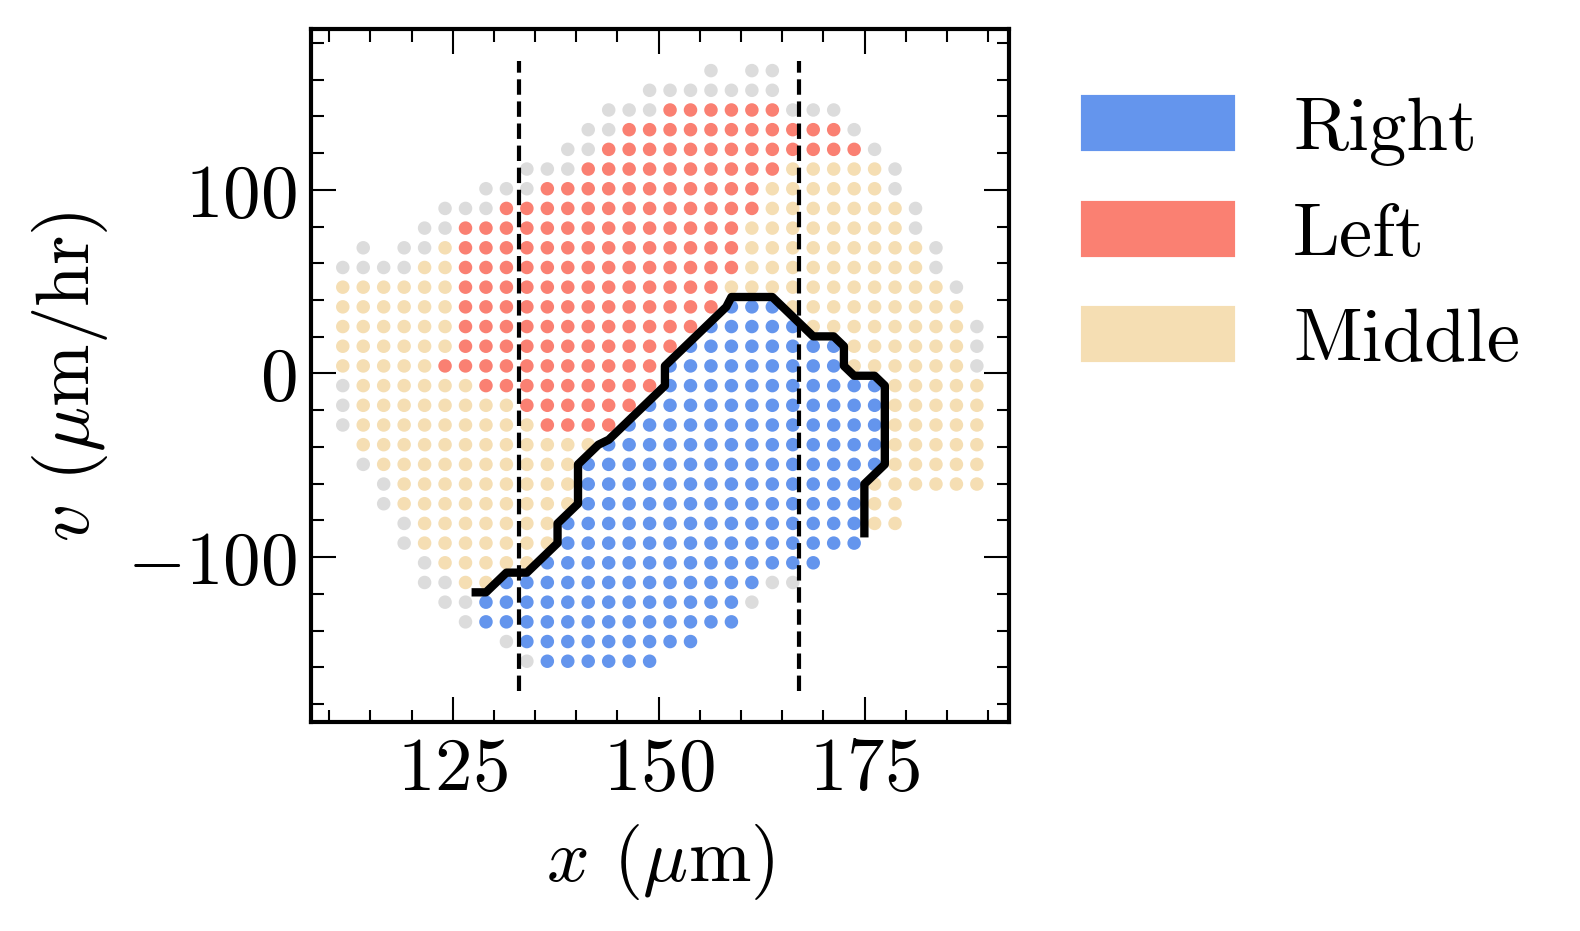

In [17]:
img = lattice_to_image(init_pts, labels, bounds_tup)
X = get_separatrices(img, levels=[0.5], origin="lower", extent=[xmin, xmax, vmin, vmax])

# plot
plt.figure(figsize=(3, 3), dpi=300)
plt.vlines(
    x=133, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)
plt.vlines(
    x=167, ymin=vmin, ymax=vmax, linewidth=1, colors=["black"], linestyles=["dashed"]
)

plt.scatter(init_pts[:, 0], init_pts[:, 1], color=labels, s=5)
plt.plot(X[:, 0], X[:, 1], lw=2, color="black")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
xlim = plt.xlim()
ylim = plt.ylim()

# Add fancy legends
import matplotlib.patches as mpatches

legend_dict = {
    "salmon": mpatches.Patch(color="salmon", label="Left"),
    "cornflowerblue": mpatches.Patch(color="cornflowerblue", label="Right"),
    "wheat": mpatches.Patch(color="wheat", label="Middle"),
}
legend = []
for c in np.unique(labels):
    legend.append(legend_dict[c]) if c != "gainsboro" else None
plt.legend(handles=legend, bbox_to_anchor=(1.01, 1))
plt.show()

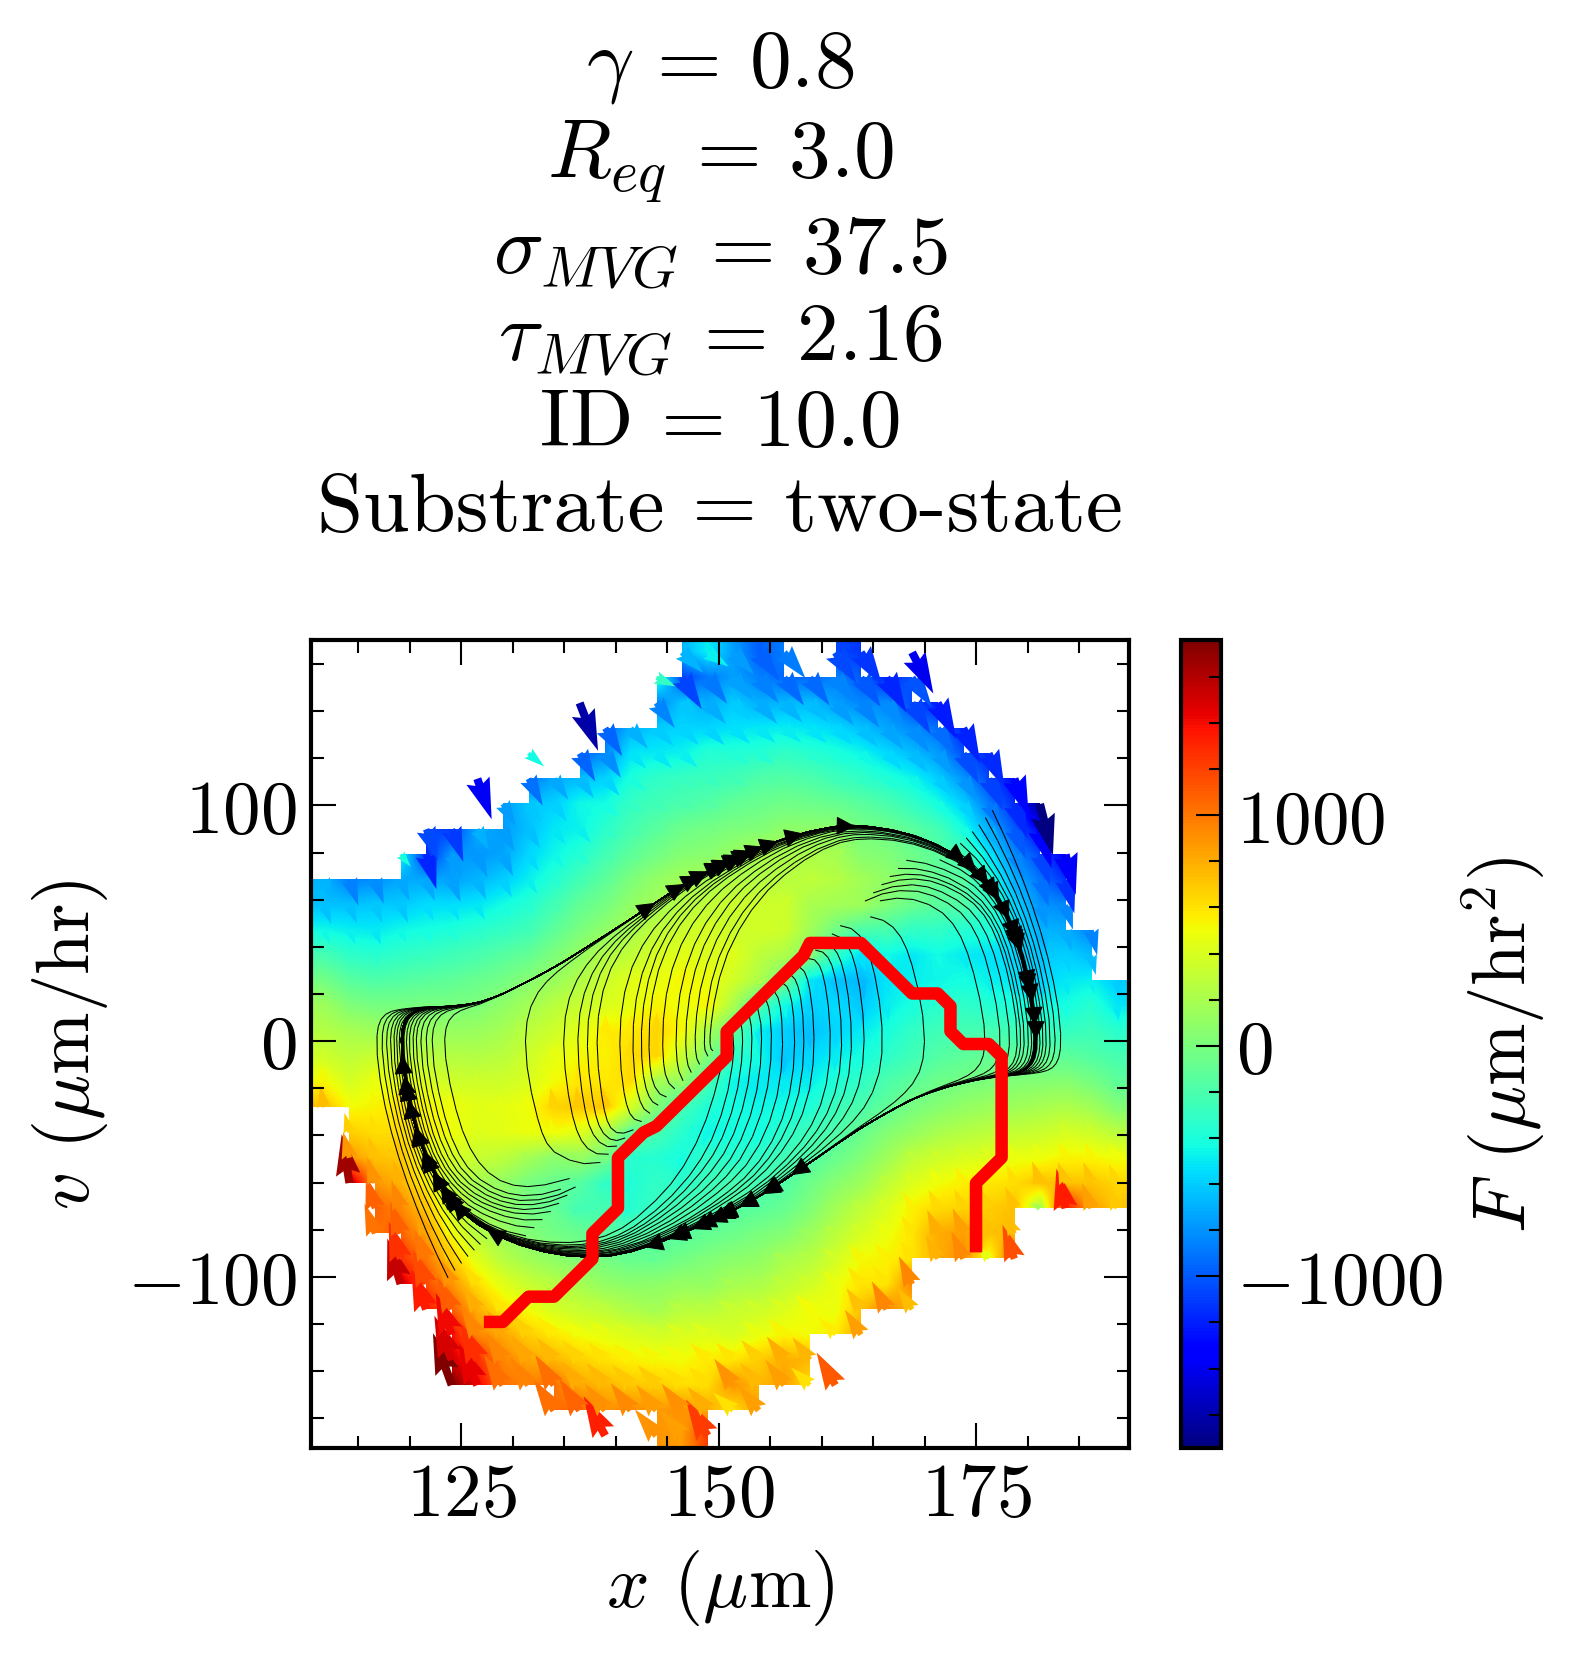

In [18]:
bounds, F, sigma = compute_F_sigma(xva_df, nbins=nbins, min_pts=1)

xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]
bounds_tup = (xmin, xmax, vmin, vmax, nbins)

plot_title = make_title(xva_df)
title = {"label": plot_title, "fontsize": 20}

init_pts = linear_lattice(xmin, xmax, vmin, vmax, n_pts=100)
# init_pts = init_pts[np.where(init_pts[np.where(init_pts[:, 0] < 155)[0]] > 145)[0]]
fig, ax = plt.subplots(1, 2, figsize=(11, 3.5), dpi=300)

ax[0].set_title(**title)
F_streamplot(
    F,
    bounds_tup,
    stream_init_pts=init_pts,
    imshow_kwargs={"interpolation": "bilinear", "origin": "lower", "cmap": "jet"},
    streamplot_kwargs={
        "integration_direction": "forward",
        "color": "black",
        "broken_streamlines": False,
        "density": 1,
        "linewidth": 0.25,
    },
    do_try=True,
    ax=ax[0],
)

ax[0].plot(X[:, 0], X[:, 1], lw=3, color="red")

im = ax[1].imshow(
    sigma,
    extent=[xmin, xmax, vmin, vmax],
    interpolation="bilinear",
    origin="lower",
    cmap="viridis",
)


ax[1].remove()

plt.subplots_adjust(wspace=0.5)
plt.show()
